### Analysing System for science publication texts, machine learning based.

#### Including:
- Text Preprocessing (tokenization, removing stop words, lemmatization and stemming)
- Construction of vector space model for document collection, Word2Vec modeling
- Calculation of semantic similarity between texts, in order to find relevant
- Texts visualisation in numerical 3-dimensional space, tSNE
- Automatic text summarization by four algorithms: TextRank, LSA, Kullback–Leibler, LexRank
- Evaluation of summaries quality by ROUGE metric
- KeyWords extraction

In [1]:
__author__ = 'Ksenia Voronaya'

import gensim
import nltk
import sklearn as sk
from sklearn.manifold import TSNE
import os
import string
import pandas as pd
import numpy as np
import itertools as itool
import matplotlib as mplot
import pylab as plb
from mpl_toolkits.mplot3d import axes3d
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
import sumy.evaluation.rouge as rouge


In [2]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kvoronaya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kvoronaya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def get_textdata(texts, colors):

    # each document will have a unique index
    file_name_mapping = {}
    
    # test_set_documents will be as a list of all texts
    # while one text is a list of all strings
    test_set_documents = list()
    
    index = 0

    for file in os.listdir(texts):
        if file.endswith('.txt'):
            text_from_file = list()
            file_name_mapping[index] = file
            index += 1
            with open(texts + file, 'r') as f:
                for line in f:
                    text_from_file.append(line.decode("ascii", "ignore"))
            
            test_set_documents.append(text_from_file)
            
    if not colors:
        colors = list(mplot.colors.cnames.keys())[:len(test_set_documents)]
        colors_mapping = {colors.index(color): color for color in colors}
    else:
        colors_mapping = colors
    
    return test_set_documents, file_name_mapping, colors_mapping
           

In [4]:
def texts_preprocessing(texts):

    processed_collection = list()
    for text in texts:
        processed_text = list()
        for line in text:
            
            # tokenization, split now on words
            tokens = nltk.word_tokenize(line)
            
            # remove stop-words
            filtered_words = [
                word for word in tokens 
                if word not in nltk.corpus.stopwords.words('english')
            ]
            
            # lemmatization and stemming process
            wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
            stemmer = nltk.stem.porter.PorterStemmer()
            processed_words = []
            for word in filtered_words:
                lemm_word = wordnet_lemmatizer.lemmatize(word)
                stemm_word = stemmer.stem(lemm_word)
                processed_words.append(stemm_word)
            
            processed_text.extend(processed_words)
        
        processed_text = ' '.join(processed_text)
        processed_collection.append(processed_text)
    
    return processed_collection

In [5]:
def vectror_space_modeling(processed_collection, words_2_vectors):
 
    tokenized_data = [nltk.word_tokenize(text) for text in processed_collection]
    corpus_texts = list()
    for text in tokenized_data:
        lemms = []
        for word in text:
            if word not in string.punctuation:
                lemms.append(word.lower())
        corpus_texts.append(lemms)
        
    # training a Word2Vec model on our process corpus of texts
    w2v_model = gensim.models.Word2Vec(corpus_texts)

    print('\n ***** Vector representation of words, for example: *****')
    for word in words_2_vectors[:2]:
        print('The word "{}" presented as vector:'.format(word))
        print(w2v_model[word])
        print('***')
    
    for word_pair in itool.combinations(words_2_vectors, 2):
        print("***** Similarity between words {} & {} *****".format(word_pair[0], word_pair[1]))
        print(w2v_model.similarity(word_pair[0], word_pair[1]))

In [6]:
def create_tfidf_matrix(n_gramm_len, collection):

    # TF-IDF matrix for corpus, term is n_gramm_len 
    corpus_tfidf = sk.feature_extraction.text.TfidfVectorizer(ngram_range=(1,n_gramm_len))
    corpus_representation = corpus_tfidf.fit_transform(collection)
    feature = corpus_tfidf.get_feature_names()
    corpus_representation_arr = corpus_representation.toarray()
    
    return corpus_tfidf, corpus_representation_arr

In [7]:
def find_similarity_texts(corpus_tfidf, corpus_representation_arr, text):

    tfidf_text = corpus_tfidf.transform([text])
    tfidf_text = tfidf_text.toarray()
    row_i = list()
    for i in range(int(corpus_representation_arr.shape[0])):
        # calculate the cosine similarity
        cosine_distance = sk.metrics.pairwise.cosine_similarity(
            corpus_representation_arr[i].reshape(1,-1), tfidf_text.reshape(1,-1))
        row_i.append(cosine_distance[0][0])
        
    return row_i

In [8]:
def analyze_similarity_texts(similarity_matrix):

    size = similarity_matrix.shape[0]
    print('\n ***** Analyzing similarity between texts: *****')
    min_similarity = similarity_matrix.values.min()
    print('\n The minimal value of similarity in collection is "{}".'.format(min_similarity))
    max_similarity = 0
    max_ind1 = None
    max_ind2 = None
    for i in range(size):
        for j in range(size):
            if i < j:
                current_val = similarity_matrix[i][j]
                if current_val == min_similarity:
                    print('\n The minimal value of similarity between the texts "{}" and "{}".'.format(i, j))
                
                if current_val > max_similarity:
                    max_similarity = current_val
                    max_ind1 = i
                    max_ind2 = j
    print('\n The maximal value of similarity in collection is "{}".'.format(max_similarity))
    print('\n The maximal value of similarity between the texts "{}" and "{}".'.format(max_ind1, max_ind2))  

In [9]:
def automatic_summarization_rouge_evaluation(texts, sentences_count, colors_mapping, file_name_mapping, file_with_summaries):

    stemmer = Stemmer("english")
    summaries_mapping = {0: 'usual TextRank', 1: 'LSA', 2: 'Kullback–Leibler', 3: 'LexRank'}
    metrics = {}
    f_index = 0
    
    print('\n \n ***** Starting an automatic summarization!!! *****')
    with open(file_with_summaries, 'w') as fff:
        for file in os.listdir(texts):
            if file.endswith(".txt"):
                rouge_metrics=list()
                val = '\n\n ************ Summaries for file {}. ************ \n'.format(file)
                print(val)
                fff.write(val)
                parsed_text = PlaintextParser.from_file(
                    texts + file, Tokenizer("english"))
                summarizers = [
                    TextRankSummarizer(stemmer), 
                    LsaSummarizer(stemmer), 
                    KLSummarizer(stemmer), 
                    LexRankSummarizer(stemmer)
                ]
                for summarizer in summarizers:
                    summarizer.stop_words = get_stop_words("english")

                summaries = [[]] * 4
                for i in range(4):
                    val1 = '\n--------- Summary by {} algorithm --------- \n'.format(summaries_mapping[i])
                    print(val1)
                    fff.write(val1)
                    for sentence in summarizers[i](parsed_text.document, sentences_count):
                        summaries[i].append(sentence)
                        print(sentence)
                        fff.write(str(sentence))

                    # computing of Recall-Oriented Understudy for Gisting Evaluation (ROUGE)
                    rouge_metrics.append(rouge.rouge_n(summaries[i], parsed_text.document.sentences, n=3))

                metrics[f_index] = rouge_metrics
                f_index += 1
               
    # visualization for ROUGE metric
    %matplotlib inline 
    texts_number = len(metrics.keys())
    width = 10
    ii = [0, 150, 300, 450]
    colorlabels = list()
    filenamescolors = list()

    fig = mplot.pyplot.figure(figsize=(20,6))
    ax = fig.add_subplot(111)

    for text_index in range(texts_number):   
        ind = list()
        for elem in ii:
            position = elem + (width * text_index)
            ind.append(position) 
        yvals = metrics[text_index]
        color = colors_mapping[text_index]
        filenamescolors.append(file_name_mapping[text_index])
        label = ax.bar(ind, yvals, width, color=color, align='center')
        colorlabels.append(label[0])
        if text_index == int(texts_number/2):
            xticks = ind

    ax.set_title('Summarization Quality')
    ax.set_ylabel('ROUGE score')
    ax.set_xticks(xticks)
    ax.set_xticklabels(('TextRank', 'LSA', 'KullbackLeibler', 'LexRank'))
    ax.grid()
    ax.legend(colorlabels, filenamescolors, loc='upper left', ncol=1, fontsize=14, bbox_to_anchor=(0, -0.03))
    mplot.pyplot.show()

In [15]:
def visualize_3d(X, mappingfeatures, features, ngramm, colors_mapping, file_name_mapping):

    # visualize data in 3d plot with popover next to mouse position.
    fig = mplot.pyplot.figure(figsize=(50,50))
    ax = fig.add_subplot(111, projection = '3d')
    set_labels = set()
    
    for i in xrange((int(X.shape[0])-1)):
        xs = X[i,0]
        ys = X[i,1]
        zs = X[i,2]

        color = None
        label = None
        
        for key in mappingfeatures.keys():
            if i in mappingfeatures[key]:
                color = colors_mapping[key]
                label = '{}'.format(file_name_mapping[key])
            
        if label in set_labels:
            label = None
        else:    
            set_labels.add(label)

        ax.scatter(xs, ys, zs, c=color, marker='o', alpha=0.5, s=120, label=label)
        
    ax.set_title('{N}-grams document visualisation in 3d space,\n based on TF-IDF matrix \n \n'.format(N=ngramm))
    ax.set_xlim(min(X[:,0]), max(X[:,0]))
    ax.set_ylim(min(X[:,1]), max(X[:,1]))
    ax.set_zlim(min(X[:,2]), max(X[:,2]))
    mplot.pyplot.legend(loc='lower left', ncol=2, fontsize=10, bbox_to_anchor=(0, 0))


    def distance(point, event):
        # return distance between mouse position and given data point

        assert point.shape == (3,), 'distance: point.shape is wrong!'
        # Project 3d data space to 2d data space
        x2, y2, _ = proj3d.proj_transform(point[0], point[1], point[2], plt.gca().get_proj())
        # Convert 2d data space to 2d screen space
        x3, y3 = ax.transData.transform((x2, y2))

        return np.sqrt ((x3 - event.x)**2 + (y3 - event.y)**2)


    def calcClosestDatapoint(X, event):
        # calculate which data point is closest to the mouse position.

        distances = [distance (X[i, 0:3], event) for i in range(X.shape[0])]
        return np.argmin(distances)


    def annotatePlot(X, index):
        #create popover label in 3d chart
        # if we have previously displayed another label, remove it first
        if hasattr(annotatePlot, 'label'):
            annotatePlot.label.remove()
        # Get data point from array of points X, at position index
        x2, y2, _ = proj3d.proj_transform(X[index, 0], X[index, 1], X[index, 2], ax.get_proj())
        annotatePlot.label = plt.annotate( '{}'.format(features[index]),
            xy = (x2,y2), xytext = (-60, 60), textcoords = 'offset points', ha = 'right', 
            va = 'top', fontsize = 20,
            bbox = dict(boxstyle = 'round,pad=0.8', fc = 'yellow', alpha = 1, ec=(1., .5, .5)),
            arrowprops = dict(arrowstyle = 'fancy', connectionstyle = 'arc3,rad=0'))
        fig.canvas.draw()


    def onMouseMotion(event):
        # event that is triggered when mouse is moved
        # shows text annotation over data point closest to mouse
        closestIndex = calcClosestDatapoint(X, event)
        annotatePlot (X, closestIndex)
    fig.canvas.mpl_connect('motion_notify_event', onMouseMotion)
    mplot.pyplot.show()

    
def make_visualisation(get_ngramm_repr, features, reduced_matr, ngramm, palette_colors, file_name_mapping):

    ngramms_number, texts_number = get_ngramm_repr.shape
    mappingfeatures = {}
    
    for i in xrange(int(texts_number)):
        features_presented = []
        corpus_representation_arr = get_ngramm_repr.transpose()
        doc_raw = enumerate(corpus_representation_arr[i])
        for ngram in doc_raw:
            if ngram[1] > 0.0:
                features_presented.append(ngram[0])

        mappingfeatures[i] = features_presented
    
    X = reduced_matr
    visualize_3d(X, mappingfeatures, features, ngramm, palette_colors, file_name_mapping)


def create_texts_visualization_3dspace(term_length, collection, palette_colors, file_name_mapping):
 
    corpus_tfidf = sk.feature_extraction.text.TfidfVectorizer(ngram_range=(term_length,term_length))
    
    corpus_representation = corpus_tfidf.fit_transform(collection)
    corpus_representation_arr = corpus_representation.toarray()
    repr_ngramms = corpus_representation_arr.transpose()
    features_ngramm = corpus_tfidf.get_feature_names()
    
    print('\n ***** Visualization process... *****')
    print('\n The size of matrix is "{}", we will reduce it with t-SNE up to (N,3)'.format(repr_ngramms.shape))
    
    # t-distributed stochastic neighbor embedding, t-SNE
    # dimensional reduction
    newtsne = TSNE(n_components=3)

    reduced_matr_ngramm = newtsne.fit_transform(repr_ngramms)
    print('\n Current size of matrix is "{}", after t-SNE.'.format(reduced_matr_ngramm.shape))
    
    make_visualisation(repr_ngramms, features_ngramm, reduced_matr_ngramm, term_length, palette_colors, file_name_mapping)


In [11]:
def keywords_extraction(collection, keywords_number):

    keywords = {}
    index = 0
    for text in collection:
        extracted_keywords =  gensim.summarization.keywords(
            text, words=keywords_number, scores=True, lemmatize=True)
        keywords[index] = extracted_keywords
        index += 1
        
    dataframe = list()  
    for value in keywords.values():
        dataframe.append(value)
    
    extracted_keywords = pd.DataFrame(dataframe, columns=['KeyWord & Score'] * keywords_number)
    print('\n ***** Extracted KeyWords: *****')
    print(extracted_keywords)        

***** Files names mapping, each document has a unique id: *****
0: "Association of Hormonal Contraception With Depression.txt"
1: "Behavioral Interventions for Antipsychotic Medication Associated Obesity.txt"
2: "Care for Adolescents with Depression in Primary Care Settings.txt"
3: "Cigarette Smoking and the Onset and Persistence of Panic Attacks During Mid-Adulthood in the United States.txt"
4: "Efficacy of Topiramate in the Treatment of Crack Cocaine Dependence.txt"
5: "Efficacy, Acceptability, and Tolerability of Antipsychotics in Treatment-Resistant Schizophrenia.txt"
6: "Exaggerated Acquisition and Resistance to Extinction of Avoidance Behavior in Treated Heroin-Dependent Men.txt"
7: "Short-term Suicide Risk After Psychiatric Hospital Discharge.txt"
8: "Treatment Preferences of Psychotherapy Patients with Chronic PTSD.txt"
9: "Use of Acetaminophen (Paracetamol) During Pregnancy .txt"

 ***** Vector representation of words, for example: *****
The word "schizophrenia" presented as v

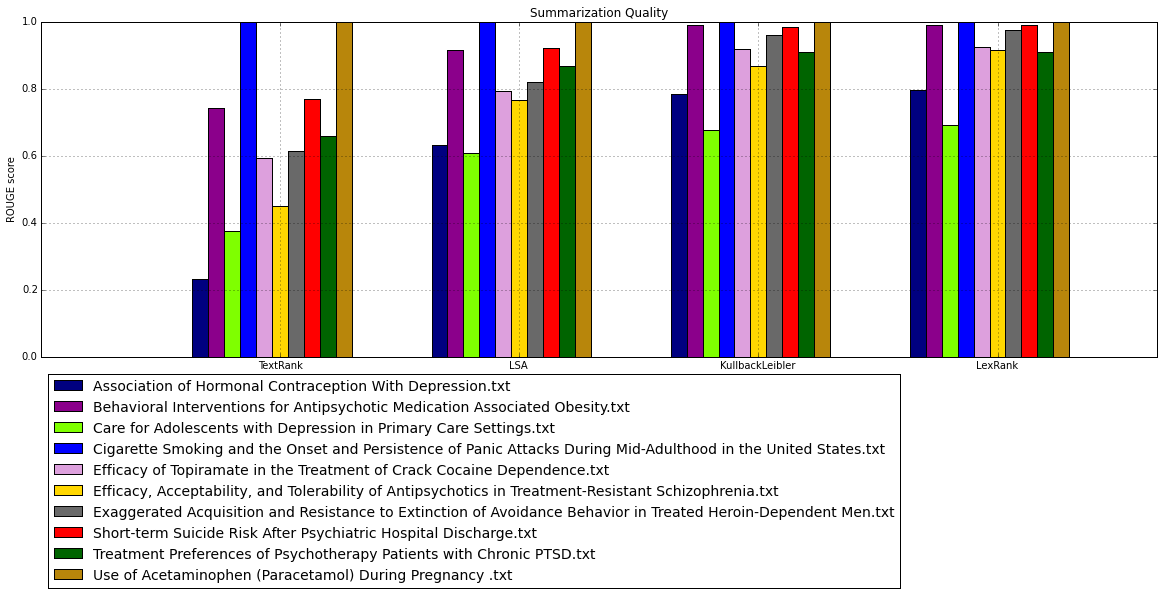


 ***** Extracted KeyWords: *****
                   KeyWord & Score               KeyWord & Score  \
0          (use, [0.308789456187])      (user, [0.250861725385])   
1      (control, [0.236328293992])       (smi, [0.202345057367])   
2         (cost, [0.327097405722])      (care, [0.269198848165])   
3        (smoke, [0.342520433405])    (attack, [0.244171534368])   
4       (cocain, [0.349197251879])     (group, [0.309082864908])   
5  (antipsychot, [0.298080620357])  (clozapin, [0.276415910585])   
6        (avoid, [0.326152383665])  (behavior, [0.277932143646])   
7       (disord, [0.377006522962])    (suicid, [0.330557696669])   
8       (prefer, [0.423537488982])   (patient, [0.369760087342])   
9         (adhd, [0.305773040403])     (studi, [0.301502860348])   

                  KeyWord & Score              KeyWord & Score  \
0  (contracept, [0.249139918558])    (woman, [0.204620416638])   
1      (interv, [0.195257588343])    (medic, [0.169572180578])   
2     (depress, [0.

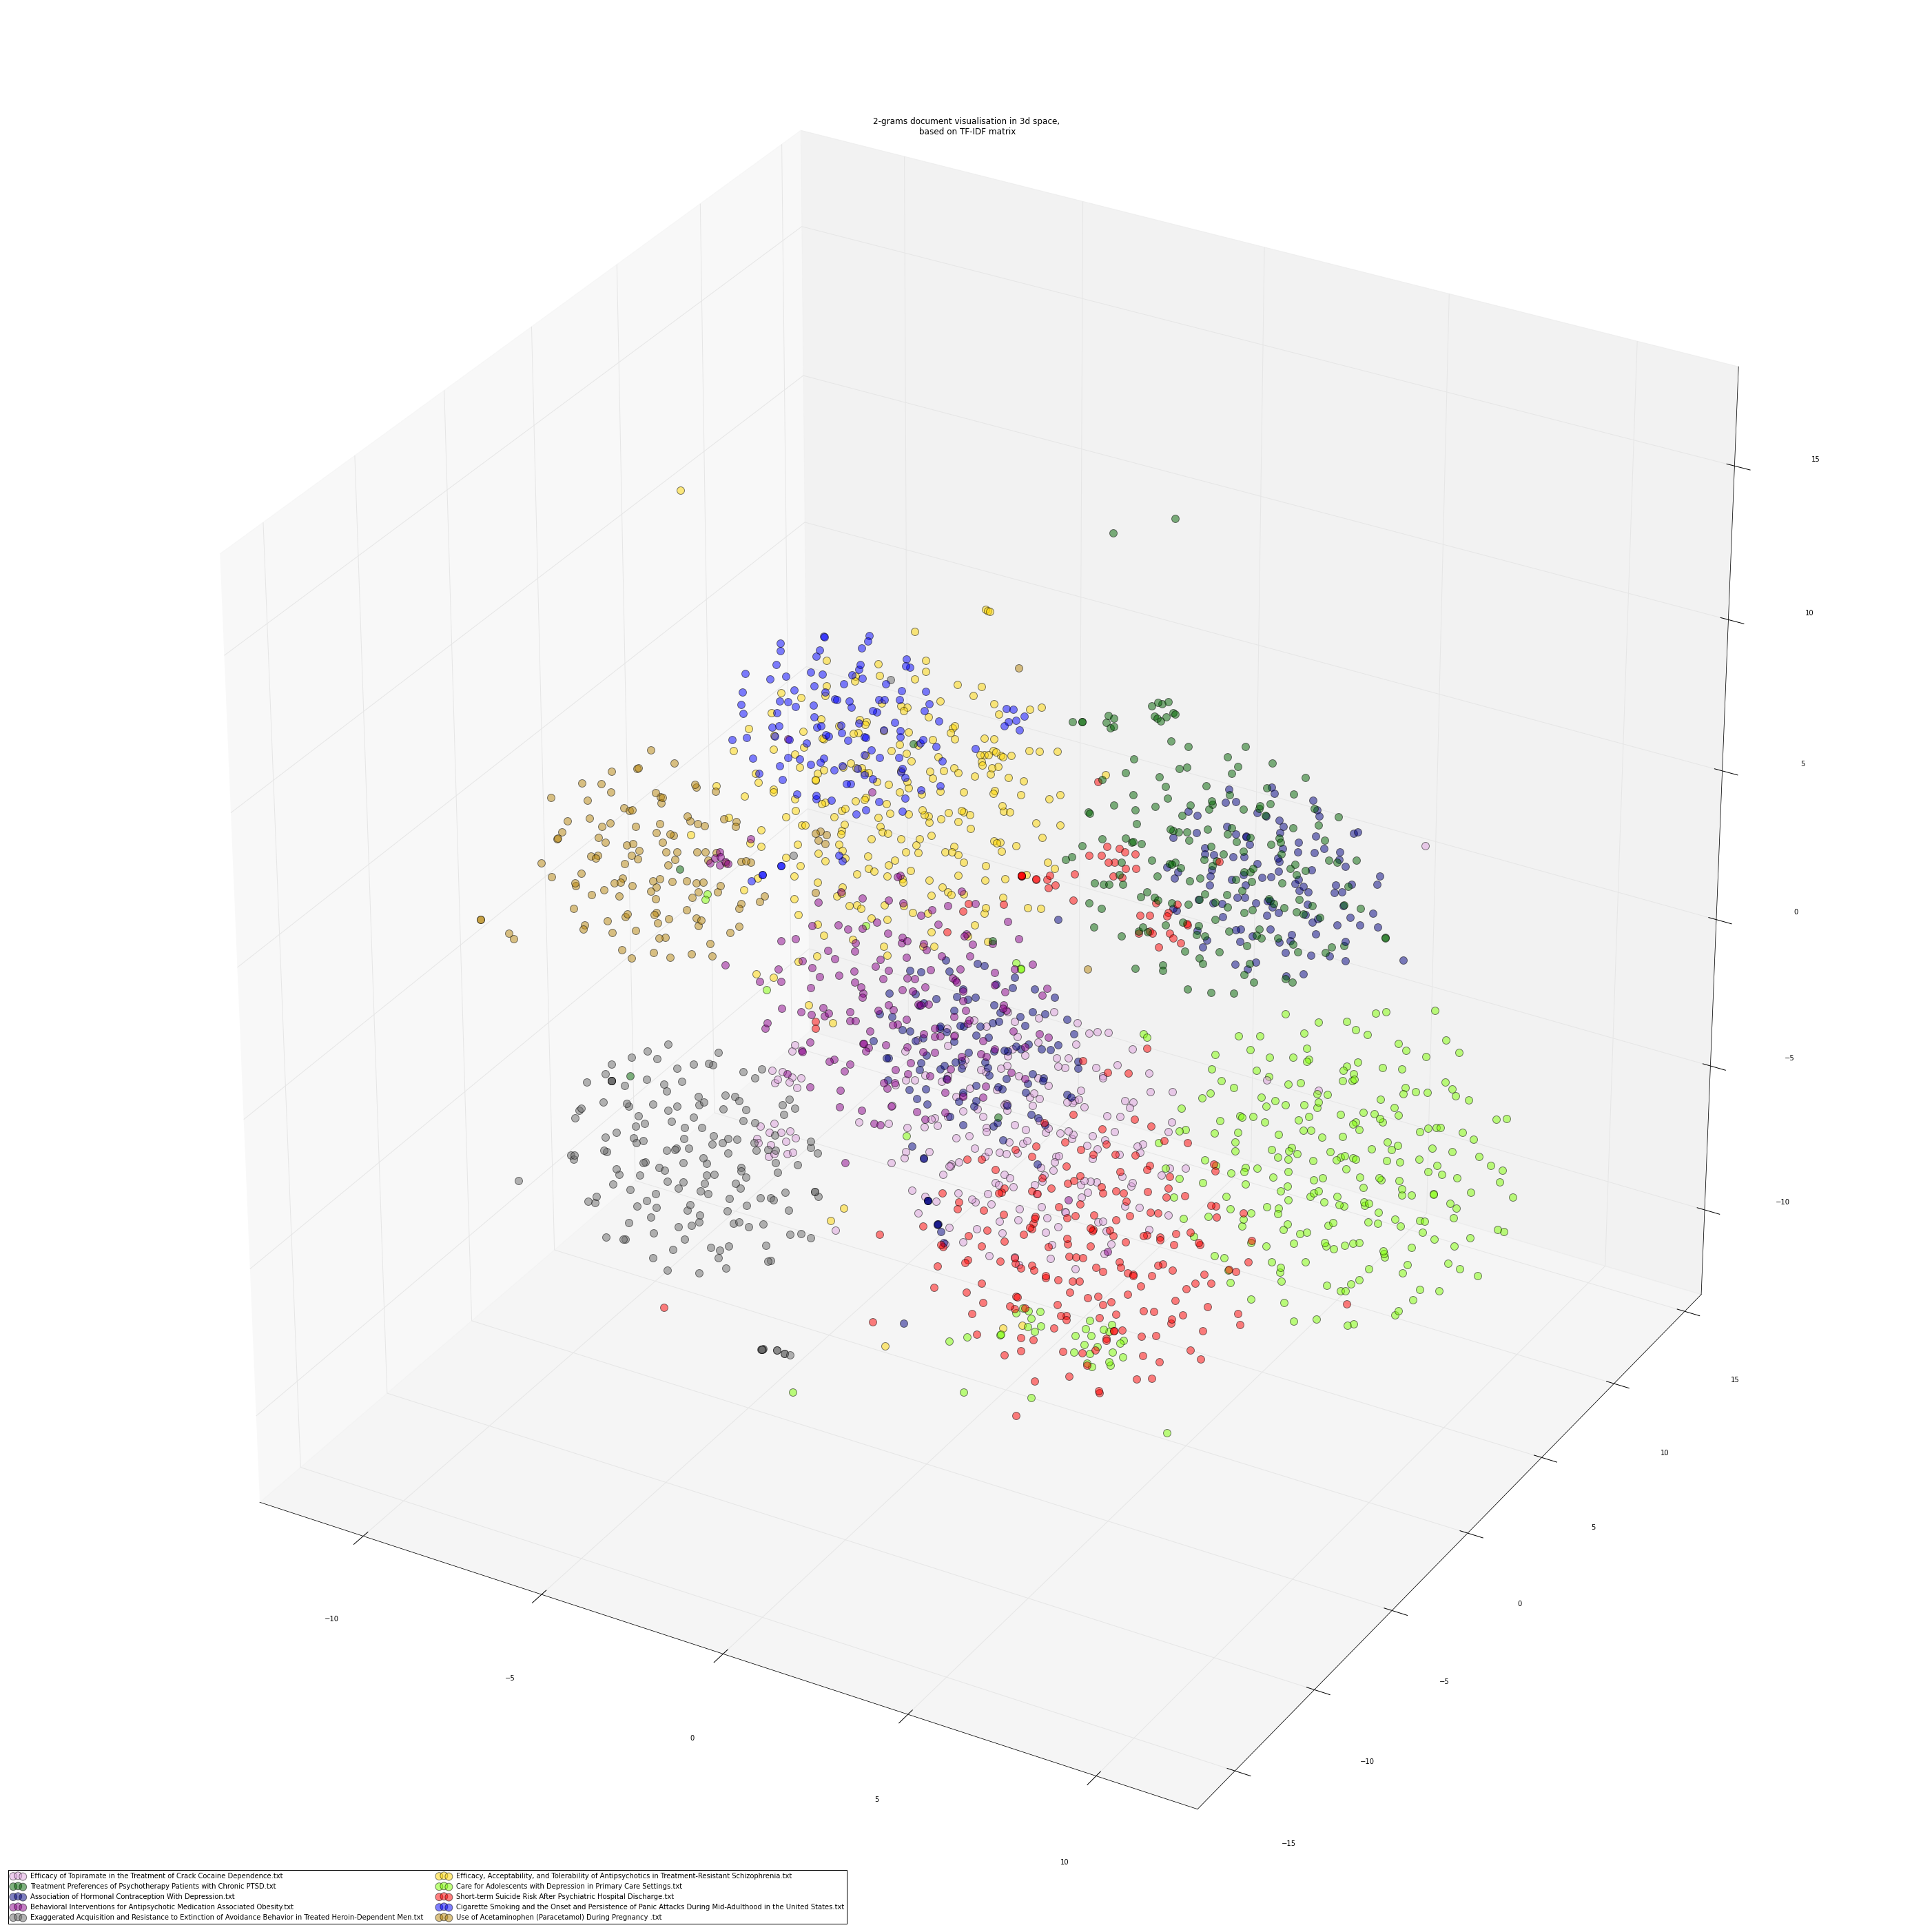

In [17]:
def main(
    texts, 
    palette_colors, 
    n_gramm, 
    term_length, 
    words_2_vectors, 
    sentences_count, 
    keywords_number, 
    file_with_summaries
):
    
    test_set_documents, file_name_mapping, colors_mapping = get_textdata(texts, palette_colors)
    
    print('***** Files names mapping, each document has a unique id: *****')           
    for k, v in file_name_mapping.items():
        print('{}: "{}"'.format(k, v))
    
    processed_collection = texts_preprocessing(test_set_documents)
    
    vectror_space_modeling(processed_collection, words_2_vectors)
    
    corpus_tfidf, corpus_representation_arr = create_tfidf_matrix(n_gramm, processed_collection)
    
    similarity_data = list()    
    for text in processed_collection:
        similarity_data.append(find_similarity_texts(corpus_tfidf, corpus_representation_arr, text))
    
    similarity_data = pd.DataFrame(similarity_data)
    print('\n ***** Similarity between the documents of collection: *****')
    print(similarity_data)
    analyze_similarity_texts(similarity_data)
    
    automatic_summarization_rouge_evaluation(
        texts, sentences_count, palette_colors, file_name_mapping, file_with_summaries)
    
    keywords_extraction(processed_collection, keywords_number)
    
    create_texts_visualization_3dspace(term_length, processed_collection, palette_colors, file_name_mapping)
    
    
if __name__ == '__main__':
    
    # put path to documents here
    path_to_texts = 'C:/Users/kvoronaya/Downloads/texts_analysing_system/UPDATED_schizophrenia_area/schizophrenia_dataset/'
    
    # if you want to use specific palette colors for analysing texts, 
    # put it here,
    # otherwise it will be compiled automatically
    
    #palette_colors = None
    palette_colors = {
        0: 'navy',
        1: 'darkmagenta',
        2: 'chartreuse',
        3: 'blue',
        4: 'plum',
        5: 'gold',
        6: 'dimgrey',
        7: 'red',
        8: 'darkgreen',    
        9: 'darkgoldenrod',
    }
    
    # n_gramm - put here the desired length for n-gramm,
    # when searching relevant texts
    n_gramm = 1
    
    # term_length - put here the desired length for n-gramm,
    # when making visualisation for texts
    term_length = 4
    
    # words_2_vectors - set of words which we want to know
    # how they represented as vectors
    # and find their similarity
    words_2_vectors = ('schizophrenia', 'treatment', 'antidepress', 'woman')
    
    # sentences_count - put here the desired number of sentences in Summary
    sentences_count = 8
    
    # file_with_summaries - put here the desired file path for summaries
    file_with_summaries = 'C:/Users/kvoronaya/Downloads/schizo_summaries.txt'
    
    # keywords_number - put here the desired number for keywords
    keywords_number = 8
    
    main(
        path_to_texts, 
        palette_colors, 
        n_gramm, 
        term_length, 
        words_2_vectors, 
        sentences_count, 
        keywords_number, 
        file_with_summaries
    )